# Dependencies

In [3]:
# standard libraries
#
import os

# mathematical and scientific
#
import numpy as np
# import sklearn as skl
# from sklearn import cluster

# geoprocessing libraries
#
import shapely as shp
import rasterio as rio
from rasterio import features
from rasterio.plot import show_hist
import fiona

# Data

In [4]:
work_dir = "./data/"
os.makedirs(work_dir, exist_ok=True)
image = f"{work_dir}LWIR_QuickMosaic_16-bit_9327.tiff"

# Classify

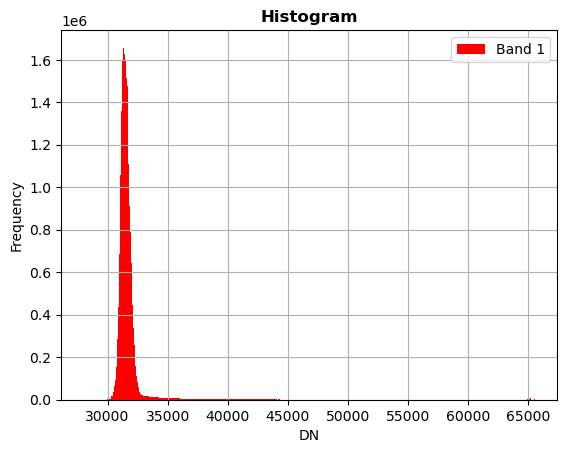

In [12]:
def find_best_class(imgfile: str) ->int:
    """For a given GeoTIFF file, find the best classification threshold."""

    # TODO: actually do this automatically!
    with rio.open(imgfile) as src:
        band1 = src.read(1)
        profile = src.profile

        show_hist(src, bins=1024, label='Band 1') #, masked=False)

    # this was found manually via trial and error below for given test tiff
    return 33332

# with rio.open(image) as src:
#     band1 = src.read(1)
#     profile = src.profile

#     # for thresh in range(30000, 36000, 1000):
#     # for thresh in range(33000, 34000, 100):
#     # for thresh in range(33300, 33400, 10):
#     for thresh in range(33330, 33340, 1):

#         with rio.open(f"{work_dir}class{thresh}.tif", 'w', **profile) as dst:
#             imgarr = np.where(band1 < thresh, 0, 1)
#             # centers, indices = cluster.kmeans_plusplus(imgarr, n_clusters=8, random_state=0)
#             # print(len(centers))
#             # print(f"{thresh}: {indices}")
#             dst.write(imgarr.astype(rio.uint8), 1)
    
#     # hist(src, bins=256, )

fire_threshold = find_best_class(image)

# Create Polygons

In [6]:
best = f"{work_dir}class{fire_threshold}.tif"
with rio.open(best) as src:
    band1 = src.read(1)
    profile = src.profile
    print(profile)

    # Convert the classified raster to polygons
    shapes = features.shapes(band1, transform=profile['transform'])

with fiona.open(f"{work_dir}class{fire_threshold}.shp", 'w', 'ESRI Shapefile',
                crs=fiona.crs.from_epsg(4326), # this is needed to create prj file
                # crs=fiona.crs.from_epsg(26910), # NAD83 UTM zone 10N THIS FAILS!
                schema={'geometry': 'Polygon', 'properties': {}}) as dst:
    for shape in shapes:
        value = shape[1]
        if value > 0:
            feature = {'geometry': shape[0], 'properties': {}}
            dst.write(feature)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5184, 'height': 12800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.671045524691221e-05, 0.0, -122.446287,
       0.0, -1.2611718749999667e-05, 41.553101000000005), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


# Aggregate Polygons

In [12]:
print(dir(shapes))
# hull = shp.concave_hull(shapes)

['__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__name__', '__ne__', '__new__', '__next__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'gi_code', 'gi_frame', 'gi_running', 'gi_yieldfrom', 'send', 'throw']
